In [1]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
from src.models.utility_models import ApiResponse


In [37]:
similarity_metrics = []

model = SentenceTransformer("all-mpnet-base-v2")

def compute_cosine_similarity(response, ref):

    # compute dense vector embeddings (768 dimensions)
    reference_embedding = model.encode(ref, convert_to_tensor=True)
    response_embedding = model.encode(response, convert_to_tensor=True)

    # compute cosine similarity
    cosine_score = util.cos_sim(reference_embedding, response_embedding)
    similarity_metrics.append(cosine_score[0].item())

    print(f"Model: {model}\nCosine Similarity Score: {cosine_score[0].item():.3f}\n")
    return cosine_score[0].item()

In [32]:
def make_api_request(url, data, headers=None, params=None):
    """Makes an HTTP POST request to the specified API endpoint.

    Args:
        url (str): The URL of the API endpoint.
        headers (dict, optional): Headers to include in the request.
        params (dict, optional): Query parameters to include in the request.
        data (dict): The api data

    Returns:
        dict: The parsed JSON response from the API.

    Raises:
        requests.exceptions.RequestException: If the request fails.
    """

    try:
        response = requests.post(url, json=data, headers=headers, params=params)
        print(response)

        # response.raise_for_status()  # Raise an exception for non-200 status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        raise SystemExit(f"API request failed: {e}")

In [123]:
df_semantic_similarity = pd.DataFrame({'question': [1,2,3,4,5,6,7,8,9,10]})
df_inference = pd.DataFrame({'question': [1,2,3,4,5,6,7,8,9,10]})


# {column TCn: []}
# Where 0 < n <= 10

In [125]:
evaluation_batches = [1,3,4,5,6,7,8,9,10,11]

In [162]:
# Make request to api for evaluation results and save data to data frame
url = f"http://localhost:5500/evaluation/batch-results"
response: ApiResponse = make_api_request(url, {
    "batch_ids": evaluation_batches
})

<Response [200]>


In [163]:
if len(response['data']) > 0:
    response_data = response['data']

In [164]:
for batch in response_data:
    scores = []
    execution_duration = []

    for item in batch['items']:
        execution_duration.append(float(item['execution_time']))
        scores.append(compute_cosine_similarity(item['response'], item['expected_response']))
    df_inference[batch['test_case_code']] = execution_duration
    df_semantic_similarity[batch['test_case_code']] = scores

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
Cosine Similarity Score: 0.800

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
Cosine Similarity Score: 0.690

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens'

In [165]:
df_semantic_similarity = df_semantic_similarity.set_index('question')
print(df_semantic_similarity)

KeyError: "None of ['question'] are in the columns"

In [147]:
df_inference = df_inference.set_index('question')
print(df_inference)

KeyError: "None of ['question'] are in the columns"

In [148]:
df_inference

,TC1,TC2,TC3,TC4,TC5,TC6,TC7,TC8,TC9,TC10
question,,,,,,,,,,
1,75.437360,83.413676,62.656820,54.089901,219.595109,53.676366,42.006312,48.644418,50.836178,95.037753
2,6.696693,6.588068,35.191904,32.737579,35.597648,4.168696,29.652768,16.169814,30.657521,55.057984
3,1.074553,0.619590,4.969446,3.980177,4.171161,3.445614,8.111799,7.902601,8.591164,9.476475
4,37.290680,42.431137,31.960881,12.563749,10.652508,28.131883,23.305908,43.341967,29.139491,82.452923
5,91.687414,74.046992,61.803848,54.921344,57.286816,27.314943,45.234108,28.322044,32.033480,61.317684
6,10.150451,18.387072,42.397674,31.253961,34.473952,42.619251,34.328236,139.500165,48.396703,16.421651
7,56.419363,37.468940,31.729314,55.396037,30.261849,56.506990,37.708521,63.744306,28.076546,76.687791
8,42.632437,38.401623,64.811758,46.074431,48.297922,42.618845,45.177663,48.967137,211.954399,38.938294
9,45.733775,117.211095,124.737305,121.855911,12.328141,63.733244,35.502765,13.947566,91.791718,105.864859


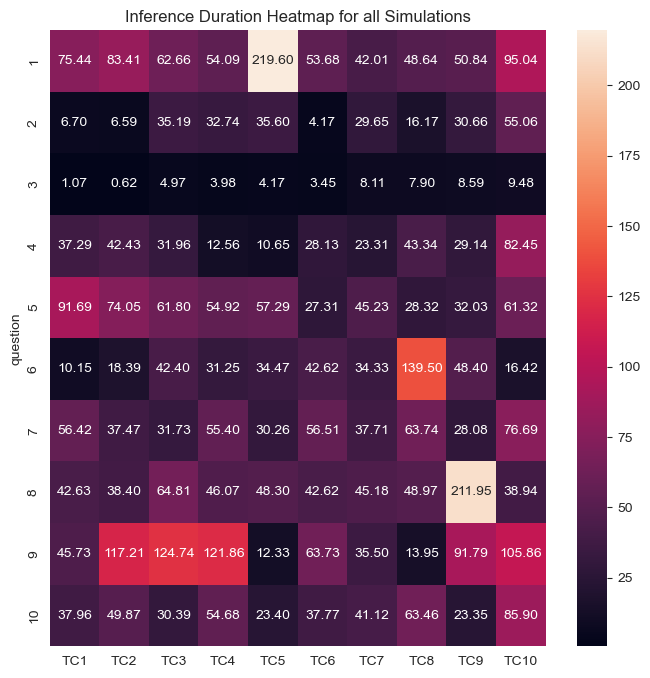

In [160]:
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df_inference, annot=True, ax=ax, fmt='.2f')
plt.title("Inference Duration Heatmap for all Simulations")
plt.show()

In [152]:
avg_inf_pq = df_inference[['TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']].mean(axis=1).reset_index()
avg_inf_ptc = df_inference[['TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']].mean().reset_index()

,index,0
0,TC1,40.507918
1,TC2,46.843759
2,TC3,49.065356
3,TC4,46.755086
4,TC5,47.606435
5,TC6,35.998847
6,TC7,34.214997
7,TC8,47.399725
8,TC9,55.483059
9,TC10,62.715189


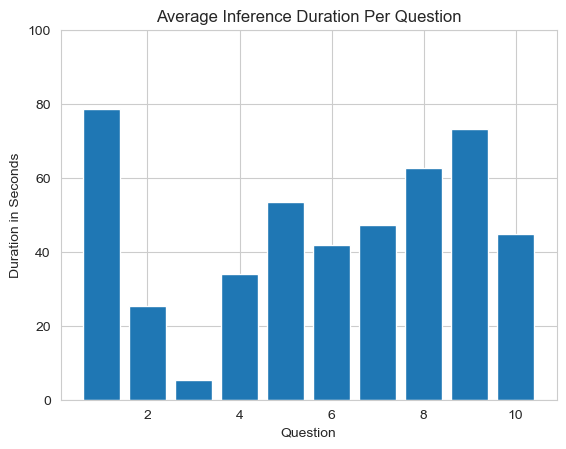

In [155]:
plt.bar(avg_inf_pq['question'], avg_inf_pq[0])
plt.title('Average Inference Duration Per Question')
plt.xlabel('Question')
plt.ylabel('Duration in Seconds')
plt.ylim(0,100)
plt.show()

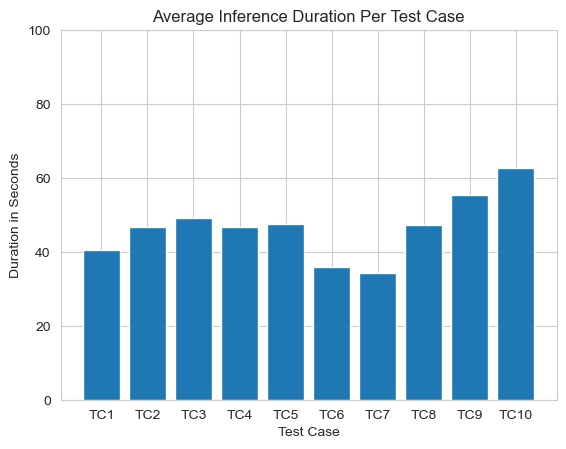

In [159]:
plt.bar(avg_inf_ptc['index'], avg_inf_ptc[0])
plt.title('Average Inference Duration Per Test Case')
plt.xlabel('Test Case')
plt.ylabel('Duration in Seconds')
plt.ylim(0,100)
plt.show()

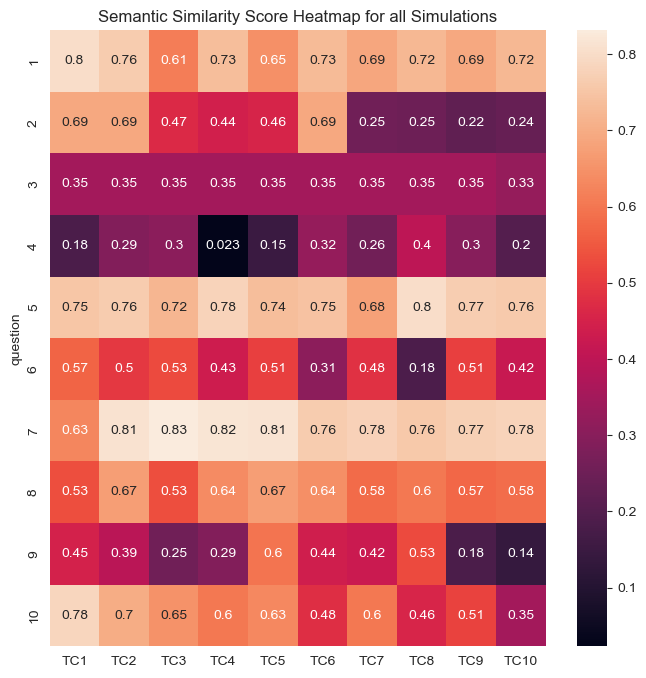

In [166]:
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df_semantic_similarity, annot=True, ax=ax)
plt.title("Semantic Similarity Score Heatmap for all Simulations")
plt.show()

In [167]:
avg_similarity_df_pq = df_semantic_similarity[['TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']].mean(axis=1).reset_index()

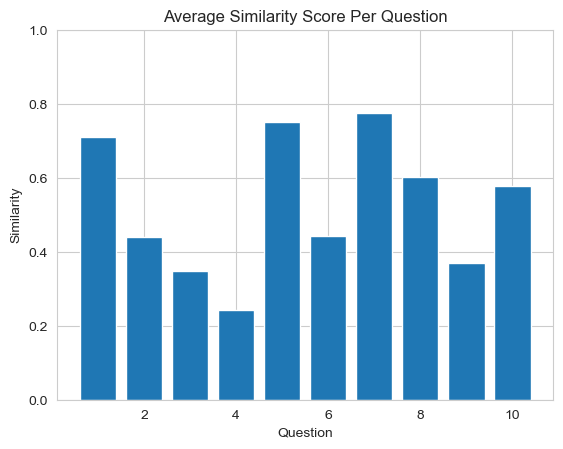

In [168]:
plt.bar(avg_similarity_df_pq['question'], avg_similarity_df_pq[0])
plt.title('Average Similarity Score Per Question')
plt.xlabel('Question')
plt.ylabel('Similarity')
plt.ylim(0,1)
plt.show()

In [169]:
avg_similarity_df_ptc = df_semantic_similarity[['TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']].mean().reset_index()


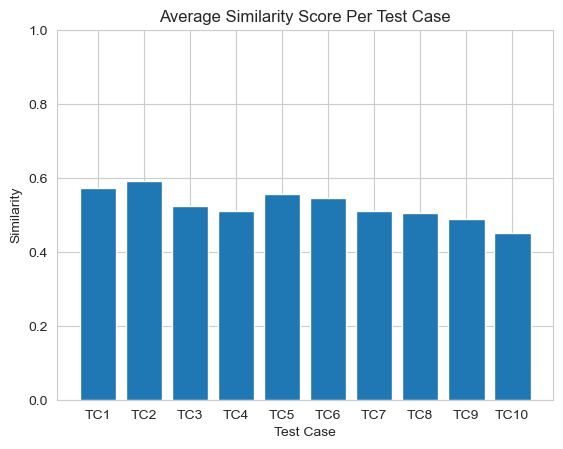

In [170]:
plt.bar(avg_similarity_df_ptc['index'], avg_similarity_df_ptc[0])
plt.title('Average Similarity Score Per Test Case')
plt.xlabel('Test Case')
plt.ylabel('Similarity')
plt.ylim(0,1)
plt.show()

In [40]:
# Save results to file:

df_semantic_similarity.to_csv("/Users/tobialao/Desktop/Software_Projects/msc_project/hiring_llm_dss_engine/resources/evaluation/semantic_similarity.csv")